In [53]:
#Introduction: Hello there. In this notebook, we will be examining gravitational waves and presenting some signal 
#processing tasks to calcualte the detection range of BBH(Binary Black Hole) mergers using LIGO Event data released 
#by the LOSC (LIGO Open Science Center). Let's get right to it!

In [54]:
#Setup: Installing the required packages and downloading the data:
!wget https://losc.ligo.org/s/events/get_datafiles.sh
!bash get_datafiles.sh
!pip install lal
!pip install pycbc==1.7.5
import numpy as np
import pylab
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import readligo as rl
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, matched_filter
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.psd import welch, interpolate
print("Download complete!")

--2017-09-21 17:27:57--  https://losc.ligo.org/s/events/get_datafiles.sh
Resolving webproxy (webproxy)... 100.112.158.176
Connecting to webproxy (webproxy)|100.112.158.176|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1029 (1.0K) [application/x-sh]
Saving to: 'get_datafiles.sh.4'

get_datafiles.sh.4  100%[===================>]   1.00K  --.-KB/s    in 0s      

2017-09-21 17:27:57 (44.8 MB/s) - 'get_datafiles.sh.4' saved [1029/1029]

--2017-09-21 17:27:57--  https://losc.ligo.org/s/events/BBH_events_v3.json
Resolving webproxy (webproxy)... 100.112.158.176
Connecting to webproxy (webproxy)|100.112.158.176|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2202 (2.2K) [application/json]
Saving to: 'BBH_events_v3.json.4'

BBH_events_v3.json. 100%[===================>]   2.15K  --.-KB/s    in 0s      

2017-09-21 17:27:58 (86.8 MB/s) - 'BBH_events_v3.json.4' saved [2202/2202]

--2017-09-21 17:27:58--  https://losc.ligo.org/s/sample_code

Download complete!


In [55]:
#Settings: Selecting an event and plot type
eventname = ''
eventname = 'GW150914' 
#eventname = 'GW151226' 
#eventname = 'LVT151012'
#eventname = 'GW170104'
make_plots = 1
plottype = "png"
#plottype = "pdf"

In [56]:
#Error Check: Reading the event properties from a local json file and printing an error in case something was missing
fnjson = "BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()
try: 
    events[eventname]
except:
    print('You must select an eventname that is in '+fnjson+'! Quitting.')
    quit()

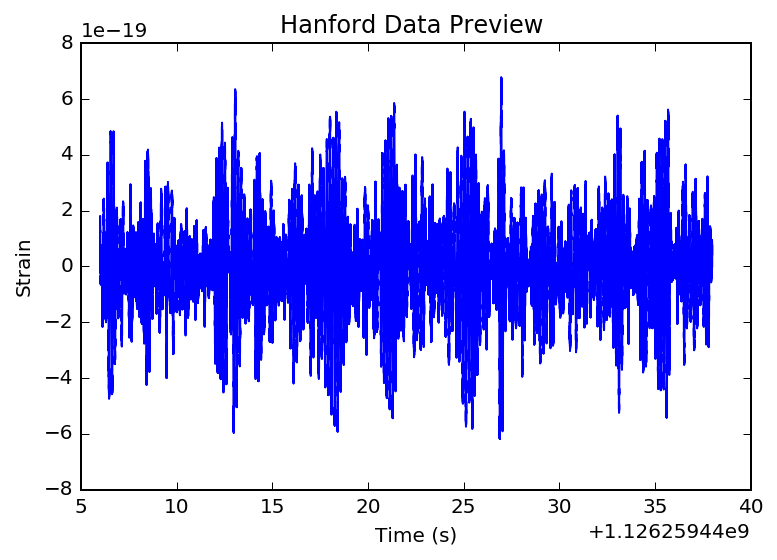

In [57]:
#Preview of Data: Reading the Hanford data from one of the files we downloaded
h1 = read_frame('H-H1_LOSC_4_V2-1126259446-32.gwf', 'H1:LOSC-STRAIN') #Reading the file
h1 = highpass_fir(h1, 15, 16) #Filtering the data, getting rid of low frequency data
pylab.plot(h1.sample_times, h1)#Plotting the data
plt.title('Hanford Data Preview ')
plt.ylabel('Strain')
plt.xlabel('Time (s)')

In [58]:
#Learn more about the data: Extract and print parameters for the desired event and read in data from H1 and L1. 
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # Frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])
print(event)
try:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
except:
    print("Cannot find data files!")
    print("You can download them from https://losc.ligo.org/s/events/"+eventname)
    print("Quitting.")
    quit()   
time = time_H1
dt = time[1] - time[0]
#Printing properties of time and strain values:
print('time_H1: len, min, mean, max = ', \
    len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max() )
print('strain_H1: len, min, mean, max = ', \
    len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max())
print( 'strain_L1: len, min, mean, max = ', \
    len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max())
bits = chan_dict_H1['DATA']
print("For H1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
bits = chan_dict_L1['DATA']
print("For L1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))

Reading in parameters for event GW150914
{u'fband': [43.0, 300.0], u'approx': u'lalsim.SEOBNRv2', u'fs': 4096, u'name': u'GW150914', u'utcevent': u'2015-09-14T09:50:45.44', u'fn_H1': u'H-H1_LOSC_4_V2-1126259446-32.hdf5', u'a1': 0.355, u'fn_L1': u'L-L1_LOSC_4_V2-1126259446-32.hdf5', u'm1': 41.743, u'f_min': 10.0, u'fn_template': u'GW150914_4_template.hdf5', u'm2': 29.237, u'tevent': 1126259462.44, u'a2': -0.769}
('time_H1: len, min, mean, max = ', 131072, 1126259446.0, 1126259461.9998779, 1126259477.9997559)
('strain_H1: len, min, mean, max = ', 131072, -7.0446659431560669e-19, 5.8955225092464373e-23, 7.7062621923974648e-19)
('strain_L1: len, min, mean, max = ', 131072, -1.8697138664279764e-18, -1.0522332249909908e-18, -4.60035111311666e-20)
For H1, 32 out of 32 seconds contain usable DATA
For L1, 32 out of 32 seconds contain usable DATA


GPS time of event:  1126259462.44


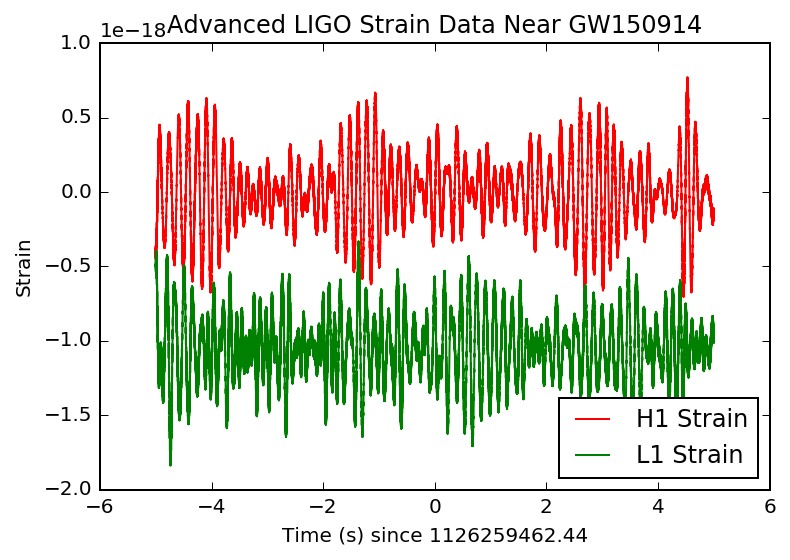

In [59]:
# Previewing event data: Here we plot data 5 seconds around the event:
deltat = 5 #Setting the time domain
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat)) #Indexing into the strain time series for this time interval
print'GPS time of event: ',tevent #Printing GPS time of event
if make_plots:
    plt.figure()
    plt.plot(time[indxt]-tevent,strain_H1[indxt],'r',label='H1 Strain')
    plt.plot(time[indxt]-tevent,strain_L1[indxt],'g',label='L1 Strain')
    plt.xlabel('Time (s) since '+str(tevent))
    plt.ylabel('Strain')
    plt.legend(loc='lower right')
    plt.title('Advanced LIGO Strain Data Near '+eventname)
    plt.savefig(eventname+'_strain.'+plottype)

Min frequency of the PSD 0.0
Max frequency of the PSD 2048.0


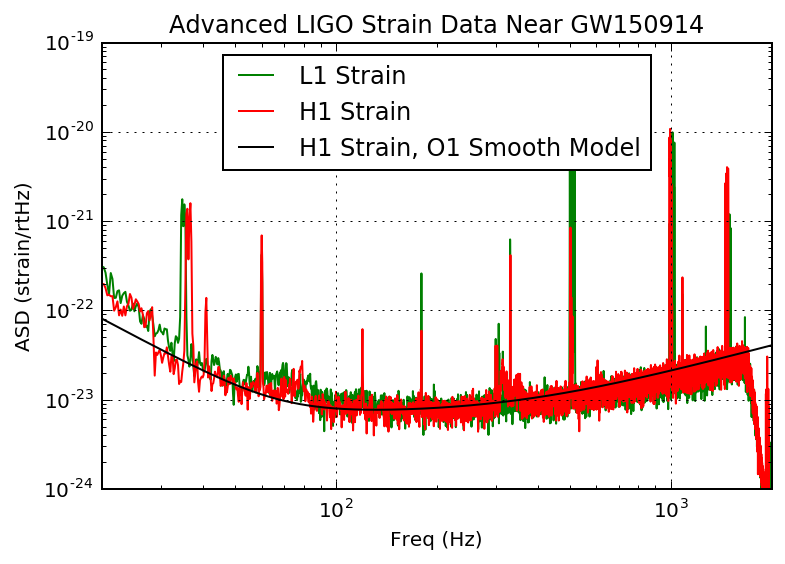

In [60]:
# Using the data: Plotting the data in the Fourier domain and as ASD. 
make_psds = 1
if make_psds:
    NFFT = 4*fs #Calculating nonequispaced fast Fourier transform using the sampling rate
    Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
    Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)
    psd_H1 = interp1d(freqs, Pxx_H1) #Use interpolations of the PSDs computed above for whitening for H1
    psd_L1 = interp1d(freqs, Pxx_L1) #Use interpolations of the PSDs computed above for whitening for L1 
    Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2 #Smoothed PSD for H1 during O1
    psd_smooth = interp1d(freqs, Pxx)
    print"Min frequency of the PSD",min(freqs)
    print"Max frequency of the PSD",max(freqs)
# Plotting the ASD vs Frequency:
if make_plots:
    f_min = 20.
    f_max = 2000. 
    plt.figure(figsize=(6,4))
    plt.loglog(freqs, np.sqrt(Pxx_L1),'g',label='L1 Strain')#Plotting ASD for L1
    plt.loglog(freqs, np.sqrt(Pxx_H1),'r',label='H1 Strain')#Plotting ASD for H1
    plt.loglog(freqs, np.sqrt(Pxx),'k',label='H1 Strain, O1 Smooth Model')#Plotting ASD for for H1 during O1
    plt.axis([f_min, f_max, 1e-24, 1e-19])
    plt.grid('on')
    plt.ylabel('ASD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper center')
    plt.title('Advanced LIGO Strain Data Near '+eventname)
    plt.savefig(eventname+'_ASDs.'+plottype)

The total mass of the BBHs is: 100
The sampling rate of the Waveform template is: 0.25


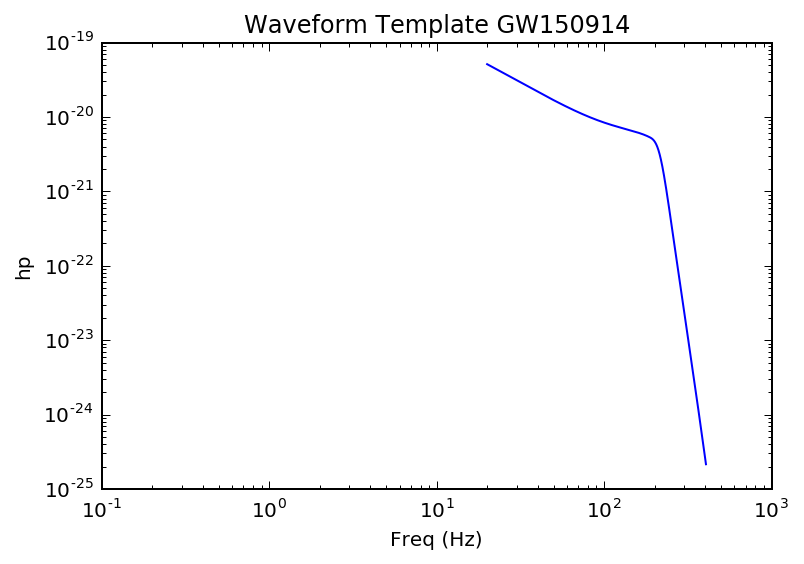

In [61]:
#Genrating the waveform template: Choosing the mass of BBHs, spin and the sampling rate
#To avoid problems make sure the total mass of the BBH merger is no less than 20 Solar masses and make sure
#the sampling rate matches that of the PSD
m1=50
m2=50
dfWaveform=0.25
#Generating the Waveform and plotting it as a function of frequency:
for apx in ['IMRPhenomPv2']:
    hp, hc = get_fd_waveform(approximant=apx,
                             mass1=m1,
                             mass2=m2,
                             spin1z=1.0,
                             delta_f=dfWaveform,
                             f_lower=20)
    a=hp.sample_frequencies
    b=np.abs(hp)
    totalmass=m1+m2 #Total mass of the system
    print "The total mass of the BBHs is:",totalmass
    print "The sampling rate of the Waveform template is:", dfWaveform
    pylab.loglog(hp.sample_frequencies, np.abs(hp), label=apx)
    plt.ylabel('hp')
    plt.xlabel('Freq (Hz)')
    plt.title('Waveform Template '+eventname)

The sampling rate of the PSD is:  0.25
The total mass of the BBHs is: 100
The sampling rate of the Waveform template is: 0.25
For accurate data the maximum frequency of the waveform template should not always be less than the PSD maximum frequency
Minimum frequency of the waveform template is: 0.0 Hz
Maximum frequency of the waveform template is: 512.0 Hz
Maximum frequency of the PSD is: 2048 Hz
H1 BBH inspiral horizon = 3202.6 Mpc, BBH inspiral range   = 1414.1 Mpc
L1 BBH inspiral horizon = 2748.8 Mpc, BBH inspiral range   = 1213.7 Mpc


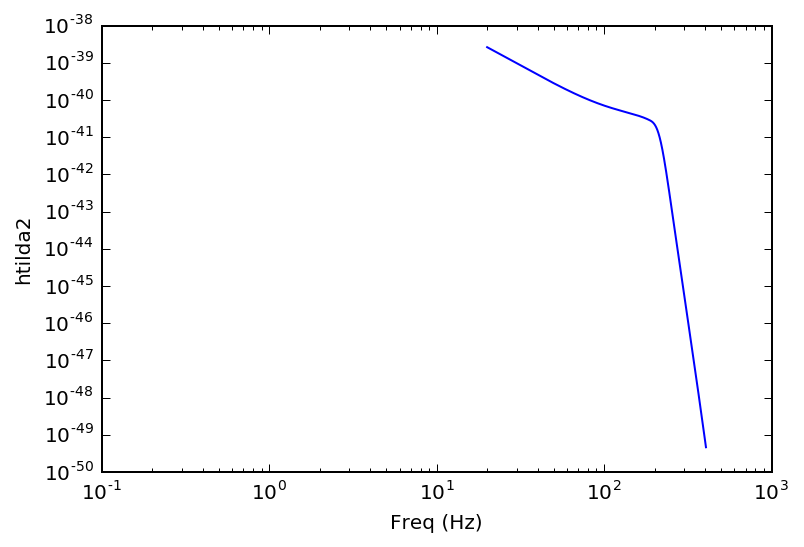

In [62]:
#Computing BBH Mergers detection range:
f = freqs.copy() #Choosing a detector noise power spectrum
df = f[2]-f[1] #Choosing frequency step size
#Printing some information about the waveform and PSD:
print "The sampling rate of the PSD is: " ,df
print "The total mass of the BBHs is:",totalmass
print "The sampling rate of the Waveform template is:", dfWaveform
print"For accurate data the maximum frequency of the waveform template should not always be less than the PSD maximum frequency"
SNRdet = 8. #Signal-to-noise ratio
Favg = 2.2648 #Conversion constant between maximum amplitude and average horizion
#Restricting the maximum and minimum frequency for the waveform tempelate:
f_waveform_min = min(hp.sample_frequencies) #Hz
f_waveform_max=max(hp.sample_frequencies) #Hz
print"Minimum frequency of the waveform template is:",min(hp.sample_frequencies), "Hz"
print "Maximum frequency of the waveform template is:",max(hp.sample_frequencies), "Hz"
print "Maximum frequency of the PSD is: 2048 Hz"
fr = np.nonzero(np.logical_and(f >= f_waveform_min , f <= f_waveform_max)) #Constructing frequecny domain
ffr = f[fr] #Applying the frequency domain to the detector noise power spectrum

#Calculation:
# Calcualting Htilda and plotting it:
htilda=b
htilda2=np.power(htilda,2)
pylab.loglog(hp.sample_frequencies, htilda2, label=apx)
plt.ylabel('htilda2')
plt.xlabel('Freq (Hz)')
#Calculating the BBH detection horizion and range over both detectors:
dets = ['H1', 'L1']
for det in dets:
    if det is 'L1': sspec = Pxx_L1.copy() #PSD Data for L1
    else:           sspec = Pxx_H1.copy() #PSD Data for H1
    sspecfr = sspec[fr] #Applying frequency domain to the PSD Data
    D_BNS = np.sqrt(4.*np.sum(htilda2/sspecfr)*df)/SNRdet #Calculating horizion range
    R_BNS = D_BNS/Favg #Calculating detection range from horizion distance and conversion constant
    print(det+' BBH inspiral horizon = {0:.1f} Mpc, BBH inspiral range   = {1:.1f} Mpc'.format(D_BNS,R_BNS))

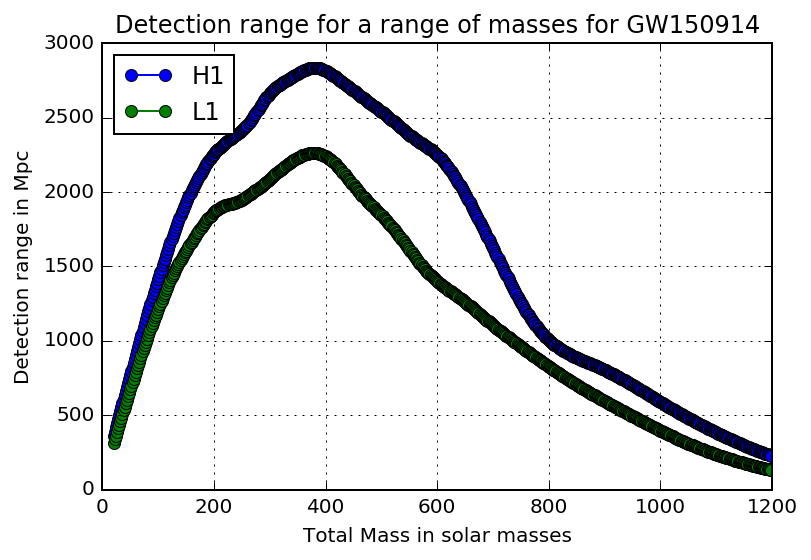

In [63]:
#Calcualting the BBH detection range for a range of masses: Choosing the range of masses of BBHs, spin and the sampling rate
#To avoid problems make sure your the total mass of the BBH merger is no less than 20 Solar masses and make sure
#the sampling rate matches that of the PSD
m1=10
m2=10
TMass_H1=[] #Creating arrays for Masses for H1
DRange_H1=[] #Creating arrays for detection ranges for H1
TMass_L1=[] #Creating arrays for Masses for L1
DRange_L1=[] #Creating arrays for detection range for L1
while m1<600 and m2<600:
    dfWaveform=0.25
    for apx in ['IMRPhenomPv2']:
        hp, hc = get_fd_waveform(approximant=apx,
                                 mass1=m1,
                                 mass2=m2,
                                 spin1z=1.0,
                                 delta_f=dfWaveform,
                                 f_lower=10.)
        a=hp.sample_frequencies
        b=np.abs(hp)
        totalmass=m1+m2 #Total mass of the system
    f = freqs.copy() #Choosing a detector noise power spectrum
    df = f[2]-f[1] #Choosing frequency step size
    SNRdet = 8. #Signal to noise ratio
    Favg = 2.2648 #Conversion constant between maximum amplitude and average horizion
#The maximum and minimum frequency for the waveform tempelate:
    f_waveform_min = min(hp.sample_frequencies) #Hz
    f_waveform_max=max(hp.sample_frequencies) #Hz
    fr = np.nonzero(np.logical_and(f >= f_waveform_min , f <= f_waveform_max))#Constructing frequecny domain
    ffr = f[fr] #Applying the frequency domain to the detector noise power spectrum
    
#Calculating the BBH detection horizion and range over both detectors looping over a range of masses:
    htilda=b
    htilda2=np.power(htilda,2)
    sspec = Pxx_H1.copy() #PSD Data for H1
    sspecfr = sspec[fr] #Applying frequency domain to the PSD Data for H1
    D_BBH = np.sqrt(4.*np.sum(htilda2/sspecfr)*df)/SNRdet #Calculating horizion range
    R_BBH = D_BBH/Favg #Calculating detection range from horizion distance and conversion constant
    TMass_H1.append(totalmass) #Adding the mass to the H1 array
    DRange_H1.append(R_BBH) #Adding the detection range to the H1 array
    sspec = Pxx_L1.copy() #PSD Data for L1
    sspecfr = sspec[fr] #Applying frequency domain to the PSD Data for L1
    D_BBH = np.sqrt(4.*np.sum(htilda2/sspecfr)*df)/SNRdet #Calculating horizion range
    R_BBH = D_BBH/Favg #Calculating detection range from horizion distance and conversion constant
    TMass_L1.append(totalmass) #Adding the mass to the L1 array
    DRange_L1.append(R_BBH) #Adding the detection range to the L1 array
    m1+=1 
    m2+=1
plt.plot(TMass_H1,DRange_H1,'-o',label='H1')
plt.plot(TMass_L1,DRange_L1,'-o',label='L1')
plt.ylabel('Detection range in Mpc')
plt.xlabel('Total Mass in solar masses')
plt.title('Detection range for a range of masses for '+eventname)
plt.legend(loc='upper left')
plt.grid('on')

In [64]:
#References:
#M Vallisneri et al. "The LIGO Open Science Center", proceedings of the 10th LISA Symposium, University of Florida, Gainesville, May 18-23, 2014; also arxiv:1410.4839 
#https://github.com/ligo-cbc/binder/blob/master/Make_waveform.ipynb
#https://notebooks.azure.com/nitz/libraries/pycbc
#https://dcc.ligo.org/LIGO-T1100338/public
#https://arxiv.org/abs/1003.2480
#https://arxiv.org/abs/gr-qc/0509116
#https://arxiv.org/abs/1203.2674
#https://losc.ligo.org/s/events/GW150914/LOSC_Event_tutorial_GW150914.html
#"This research has made use of data, software and/or web tools obtained from the LIGO Open Science Center 
#(https://losc.ligo.org), a service of LIGO Laboratory and the LIGO Scientific Collaboration. LIGO is funded by the U.S. National Science Foundation." 